In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 43.4 MB/s 
     |████████████████████████████████| 3.5 MB 19.3 MB/s 
     |████████████████████████████████| 2.5 MB 43.6 MB/s 
     |████████████████████████████████| 750 kB 28.8 MB/s 
     |████████████████████████████████| 407 kB 34.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=327e7ff749e40c58253f2d317da20b08a9bf1b5efdb8957d82bc43f122b709ea
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [3]:
import numpy as np
import torch
import torch_geometric
import torch.nn.functional as F
from torch_geometric.utils import subgraph
from torch_geometric.datasets import AmazonProducts
import torch_geometric.transforms as T
from torch_geometric.nn import ClusterGCNConv, GATConv, SAGEConv, TransformerConv, LayerNorm,GMMConv
from torch_geometric.loader import GraphSAINTRandomWalkSampler
import networkx as nx
from sklearn.metrics import accuracy_score, recall_score, f1_score

## Load the dataset

In [4]:
# dataset = 'Computers'
root='./drive/My Drive/dataset'
dataset = AmazonProducts(root, transform=T.TargetIndegree())


In [5]:
data = dataset[0]

## Data Exploration

Given this dataset, a question that might come to mind is whether the frequency of two products being bought together is related with their category.
In the follow in Histogram we will figure out whether two items that are more frequetly bought together, are also more likely to belong in the same class.

In [ ]:
import math
import numpy as np

def same_class(a, b):
  return torch.logical_and(a, b).sum() > 0

productsCount = np.zeros(10)
sameClassCount = np.zeros(10)
# Iterate through the first 264339468 edges
for edge_index in range(26433946):
  freqIndex = math.floor(data.edge_attr[edge_index]*10)
  if (freqIndex == 10):
    freqIndex = 9

  productsCount[freqIndex] +=1
  # If they belong in the same class 
  if same_class(data.y[data.edge_index[0][edge_index]], data.y[data.edge_index[1][edge_index]]):
    sameClassCount[freqIndex] +=1


In [ ]:
# Divide same class products with products count of each frequency index
np.seterr(divide='ignore', invalid='ignore')
y = np.nan_to_num(sameClassCount/productsCount)


[0.12605997 0.12069533 0.11200213 0.13055347 0.12563538 0.12590081
 0.09450767 0.03587444 0.06547619 0.03914141]

[2.195344e+06 3.191010e+05 8.255200e+04 2.527700e+04 1.180400e+04
 4.718000e+03 2.021000e+03 1.115000e+03 6.720000e+02 7.920000e+02]


We end up with the following graph, where the x axis is the frequency of two products being bought together (divided into 10 bars) and the y axis is the percentage of items that belong in the same category.


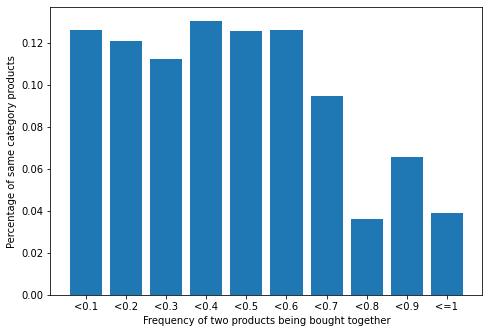

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Frequency of two products being bought together')
ax.set_ylabel('Percentage of same category products')
langs = ['<0.1', '<0.2', '<0.3', '<0.4', '<0.5', '<0.6', '<0.7', '<0.8', '<0.9', '<=1']
ax.bar(langs, y)
plt.show()

As we see, the items that are frequently bought together, are less likely to belong in the same category. Therefore the edges attribute is not sufficient in order to classify the products, and as a result we certainly need to take advantage of the nodes features.

## Baseline

According to the visualization results, products of the same category are close to each other in the Euclidean space of the node feature. Therefore, we use KNN (K=5) as the baseline, i.e. assign one item with the category that the K nearest items vote.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5).fit(data.x[data.train_mask], 
              data.y[data.train_mask])

predict_y = clf.predict(data.x[data.test_mask])

In [ ]:
f1 = f1_score(data.y[data.test_mask].cpu().detach().numpy(), predict_y, average='micro' )
f1

0.3131168170730656

We also tried RidgeClassifier.

In [ ]:
from sklearn.linear_model import RidgeClassifierCV
clf = RidgeClassifierCV().fit(data.x[data.train_mask],data.y[data.train_mask])
predict_y = clf.predict(data.x[data.test_mask])
f1 = f1_score(data.y[data.test_mask].cpu().detach().numpy(), predict_y, average='micro' )
f1

0.08338830170734325

## Graph Neural Network
### Graph Sampling

The Amazon dataset is too large to do a full-batch training of GNN because GPU memory is limited. Also, in standard SGD, if we sample nodes independently in a mini-batch, sampled nodes tend to be isolated from each other and GNN cannot access to neighboring nodes to aggregate their node features. Therefore, we consider using graph samplers to enable message-passing over small subgraphs in each mini-batch and only the subgraphs need to be loaded on a GPU at a time. 

Existent methods include neighbor sampling [Hamilton et al. NeurIPS 2017] (https://arxiv.org/abs/1706.02216), Cluster-GCN [Chiang et al. KDD 2019] (https://arxiv.org/abs/1905.07953) and GraphSAINT sampler (https://arxiv.org/abs/1907.04931), because in  the GraphSAINT paper the GraphSAINT sampler outperforms the other two. Specifically, we use the random walk based sampler with walk length 4, batch size 1500, num_steps (The number of iterations per epoch) 5, sample coverage (How many samples per node should be used to compute normalization statistics) 100. 

In [8]:

tr_loader = GraphSAINTRandomWalkSampler(data, batch_size=1500, walk_length=4,
                                     num_steps=5, sample_coverage=100,
                                     save_dir=dataset.processed_dir,
                                     num_workers=4)
test_loader = GraphSAINTRandomWalkSampler(data, batch_size=1500, walk_length=4,
                                     num_steps=5, sample_coverage=100,
                                     save_dir=dataset.processed_dir,
                                     num_workers=4)

### Model definition, training and testing

The architecture we first consider is 3 ClusterGCNConv layers, which is the ClusterGCN graph convolutional operator from [Chiang et al. KDD 2019] ($\mathbf{X}^{\prime} = \left( \mathbf{\hat{A}} + \lambda \cdot
\textrm{diag}(\mathbf{\hat{A}}) \right) \mathbf{X} \mathbf{W}_1 +
\mathbf{X} \mathbf{W}_2$

where $\mathbf{\hat{A}} = {(\mathbf{D} + \mathbf{I})}^{-1}(\mathbf{A}+\mathbf{I})$), with elu (Exponential Linear Unit) as the activation function.

Considering the previous knowledge that the category of one item may not have much to do with its neighbors in the graph. Instead, the node feature itself may contain more information about its category. Therefore,  we add residual connection between the convolution layers.

In [ ]:
import torch_geometric.nn


class Net(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        in_channels = dataset.num_node_features
        out_channels = dataset.num_classes

        self.conv1 = ClusterGCNConv(in_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.conv2 = ClusterGCNConv(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.conv3 = ClusterGCNConv(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.conv4 = ClusterGCNConv(hidden_channels, out_channels)
        self.lin4 = torch.nn.Linear(hidden_channels, out_channels)

       
    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = F.elu(self.conv3(x, edge_index) + self.lin3(x))
        x = self.conv4(x, edge_index) + self.lin4(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(hidden_channels=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    total_loss = total_examples = 0
    for batch in tr_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        criterion_weighted = torch.nn.BCEWithLogitsLoss(weight=batch.node_norm[batch.train_mask].unsqueeze(1), reduction="sum")
        loss = criterion_weighted(out[batch.train_mask], batch.y[batch.train_mask, :num_classes].float())
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_nodes
        total_examples += data.num_nodes
    return total_loss / total_examples


@torch.no_grad()
def test():
    model.eval()
    test_f1s = []
    val_f1s = []
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        
        pred = out.sigmoid() > 0.5
        test_f1 = f1_score(batch.y[batch.test_mask, :num_classes].cpu().detach().numpy(), 
                      pred[batch.test_mask].cpu().detach().numpy(), average='micro' ) 
        val_f1 = f1_score(batch.y[batch.val_mask, :num_classes].cpu().detach().numpy(), 
                      pred[batch.val_mask].cpu().detach().numpy(), average='micro' ) 
        
        test_f1s.append(test_f1)
        val_f1s.append(val_f1)
    
    return np.mean(val_f1s), np.mean(test_f1s)


best_val_score, test_score = 0.0, 0.0
best_test_score = 0.0
for epoch in range(1, 501):
    loss = train()
    val_f1, te_f1 = test()
    if best_val_score < val_f1:
      best_val_score = val_f1
      test_score = te_f1
    if best_test_score < te_f1:
      best_test_score = te_f1
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val:{val_f1:.4f}, Test: {te_f1:.4f}')
print(best_val_score, test_score)
print(best_test_score)